In [270]:
!pip install -q ipyleaflet scipy datashader

import itertools
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as widgets
import pandas as pd

from scipy.cluster.hierarchy import linkage, dendrogram
from collections import defaultdict
from util import dataset
from util.geo import mean_latlong, latlong_from_3d, latlong_to_3d, euclidian_dist, haversine_dist, dist_to_angle

from ipyleaflet import Marker, Map, CircleMarker, MarkerCluster, LayerGroup

import datashader

In [4]:
us_states = set([
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
])
def is_us(business):
    return business['state'] in us_states
def is_food(business):
    return ('Food' in business.categories) | ('Restaurants' in business.categories)

business = dataset.read('business', dataframe=True)
business_us = business[ business.apply(is_us, axis=1) ]
business_food = business[ business.apply(is_food, axis=1) ]
business_us_food = business_us[ business_us.apply(is_food, axis=1) ]
len(business), len(business_us), len(business_food), len(business_us_food)

(188592, 139183, 72623, 44271)

In [215]:
business_latlng = {
    x['business_id']: (x['latitude'], x['longitude'])
    for x in dataset.read('business')
    if x['latitude'] is not None and x['longitude'] is not None
}

In [234]:
reviews = pd.DataFrame([
    {
        'latitude': business_latlng[review['business_id']][0],
        'longitude': business_latlng[review['business_id']][1],
        'stars': review['stars']
    }
    for review in dataset.read('review')
    if review['business_id'] in business_latlng
])
#dataset.read('review', attrs=['business_id', 'stars'], dataframe=True)
#for review in :
#    if review['business_id'] not in business_reviews:
#        business_reviews[review['business_id']] = []
#    business_reviews[review['business_id']].append(review['stars'])

In [242]:
def noisy_loc(df, radius, repeat=1, attrs=[]):
    d = {}
    d['lat'] = np.concatenate([
        np.random.normal(loc=df.latitude, scale=radius)
        for i in range(repeat)
    ])
    d['lng'] = np.concatenate([
        np.random.normal(loc=df.longitude, scale=radius)
        for i in range(repeat)
    ])
    for attr in attrs:
        d[attr] = np.concatenate([
            np.array(df[attr])
            for i in range(repeat)
        ])
    return pd.DataFrame(d)
#noisy_loc(reviews, radius=.01, repeat=5, attrs=['stars'])

#next(business.iterrows())


In [222]:
def make_bounds(center=None, radius=None):
    radius = dist_to_angle(radius)
    ret = dict(
        x_range=(center[1] - radius, center[1] + radius),
        y_range=(center[0] - radius, center[0] + radius),
        #y_range=(45,46),
        #x_range=(-180,180),
        #y_range=(45,46),
    )
    #print(ret)
    return ret

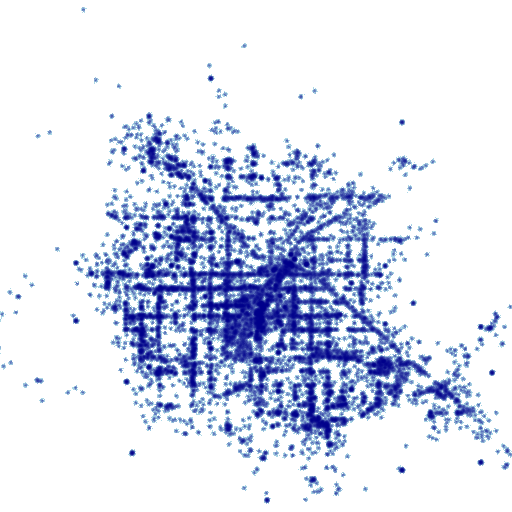

In [248]:
cvs = datashader.Canvas(plot_width=512, plot_height=512, **make_bounds(center=(36.178348, -115.176916), radius=30))
agg = cvs.points(noisy_loc(business, radius=.001, repeat=100), 'lng', 'lat', datashader.count())
img = datashader.transfer_functions.shade(agg, cmap=['lightblue', 'darkblue'],  how='eq_hist', )
img

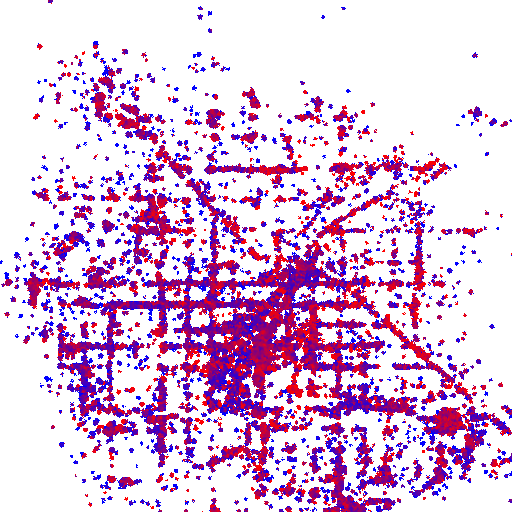

In [256]:
cvs = datashader.Canvas(plot_width=512, plot_height=512, **make_bounds(center=(36.178348, -115.176916), radius=20))
agg = cvs.points(noisy_loc(reviews, radius=.0005, repeat=5, attrs=['stars']), 'lng', 'lat', datashader.mean('stars'))
img = datashader.transfer_functions.shade(agg, cmap=['red', 'blue'],  how='eq_hist', )
img

In [269]:
def is_valid_latlng(lat, lng):
    return lat is not None and lat >= -90 and lat<=90 and \
           lng is not None and lng >= -180 and lat<=180

business_map = Map()
business_map.add_layer(MarkerCluster(
    markers=[
        Marker(
            title=business['name'],
            location=(business['latitude'], business['longitude']), 
            draggable=False,
            radius=1,
            stroke=False,
            fill_opacity=1,
            #fill_color=matplotlib.colors.to_hex(color)
        )
        for i, business in business_us_food.iterrows()
        if is_valid_latlng(business.latitude, business.longitude)
    ]))
business_map

Map(basemap={'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors',…

In [277]:
business_map = Map()
business_map.add_layer(LayerGroup(
    layers=[
        CircleMarker(
            title=business['name'],
            location=(business['latitude'], business['longitude']), 
            draggable=False,
            radius=2,
            stroke=False,
            fill_opacity=.1,
            #fill_color=matplotlib.colors.to_hex(color)
        )
        for i, business in business_us_food.iterrows()
        if is_valid_latlng(business.latitude, business.longitude)
    ]))
business_map

Map(basemap={'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors',…